# Exploratory Data Analysis
> **Warning!** Please run `01_cleaning.ipynb` first if you haven't already

In [3]:
import numpy as np
import pandas as pd
from functions.constants import BM_NAME, STARTDATE, ENDDATE, N_THRESHOLD_BPS,DATA_DIR 
from functions.helper_fns import featurize_time_series

In [4]:
active_returns_path = DATA_DIR + BM_NAME + "_active_returns.csv"
active_returns = pd.read_csv(active_returns_path, index_col=0, parse_dates=True)
print("Loaded active returns from", active_returns_path)
active_returns_thresholded_path = DATA_DIR + BM_NAME + "_active_returns_thresholded_" + str(N_THRESHOLD_BPS) + "bps.csv"
active_returns_thresholded = pd.read_csv(active_returns_thresholded_path, index_col=0, parse_dates=True)
print("Loaded active returns thresholded from", active_returns_thresholded_path)

Loaded active returns from ./../data/SP500_active_returns.csv
Loaded active returns thresholded from ./../data/SP500_active_returns_thresholded_100bps.csv


### Previewing the thresholded data 

In [5]:
TEST_TICKER = "GS UN" # Goldman Sachs--also try "AAPL UW" and "JPM UN"
TEST_PERIODS = ["1b", "1w", "1m", "1q", "1y"]
period_columns = ["active_returns_" + period for period in TEST_PERIODS]
test_ticker_df = active_returns_thresholded[active_returns_thresholded["Ticker"] == TEST_TICKER]
test_ticker_df
#True and False counts for each period 
true_counts = test_ticker_df[period_columns].sum()
false_counts = len(test_ticker_df) - true_counts
print("Col Name           || True Count || False Count")
for col in period_columns:
    print(f"{col:<18} || {true_counts[col]:<10} || {false_counts[col]}")

Col Name           || True Count || False Count
active_returns_1b  || 408.0      || 2044.0
active_returns_1w  || 800.0      || 1652.0
active_returns_1m  || 806.0      || 1646.0
active_returns_1q  || 805.0      || 1647.0
active_returns_1y  || 801.0      || 1651.0


In [6]:
# Hyperparameter for test period
TEST_PERIOD = "1b"  # This can be set to different periods like "1b", "1w", "1m", "1q", "1y"
shift_bizdays = 1
#for our given TEST_TICKER let us construct a simple strategy that forecasts 1 if yesterday's active_returns_1b was 1, 0 if it was 0
test_ticker_df = active_returns_thresholded[active_returns_thresholded["Ticker"] == TEST_TICKER]
test_ticker_df = test_ticker_df[["Ticker", "Date", f"active_returns_{TEST_PERIOD}"]] 
#soort in ascending by Ticker first then Date
test_ticker_df = test_ticker_df.sort_values(["Ticker", "Date"])
test_ticker_df[f"active_returns_{TEST_PERIOD}_forecast_dumb"] = test_ticker_df[f"active_returns_{TEST_PERIOD}"].shift(shift_bizdays)
#drop row where forecast column is NaN
test_ticker_df = test_ticker_df.dropna()
#measure precision and recall of this dumb model, get f1 score and accuracy
true_positive = len(test_ticker_df[(test_ticker_df[f"active_returns_{TEST_PERIOD}"] == 1) & (test_ticker_df[f"active_returns_{TEST_PERIOD}_forecast_dumb"] == 1)])
false_positive = len(test_ticker_df[(test_ticker_df[f"active_returns_{TEST_PERIOD}"] == 0) & (test_ticker_df[f"active_returns_{TEST_PERIOD}_forecast_dumb"] == 1)])
true_negative = len(test_ticker_df[(test_ticker_df[f"active_returns_{TEST_PERIOD}"] == 0) & (test_ticker_df[f"active_returns_{TEST_PERIOD}_forecast_dumb"] == 0)])
false_negative = len(test_ticker_df[(test_ticker_df[f"active_returns_{TEST_PERIOD}"] == 1) & (test_ticker_df[f"active_returns_{TEST_PERIOD}_forecast_dumb"] == 0)])
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)

print(f"Dumb Momentum Model that forecasts +1 if previous period's active_returns_{TEST_PERIOD} was +1, 0 if it was 0. Specific to", TEST_TICKER)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", 2 * precision * recall / (precision + recall))
print("Accuracy:", (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative))
print("True Positive:", true_positive)
print("False Positive:", false_positive)
print("True Negative:", true_negative)


Dumb Momentum Model that forecasts +1 if previous period's active_returns_1b was +1, 0 if it was 0. Specific to GS UN
Precision: 0.19852941176470587
Recall: 0.19852941176470587
F1 Score: 0.19852941176470587
Accuracy: 0.7331701346389229
True Positive: 81
False Positive: 327
True Negative: 1716


In [7]:
TEST_PERIOD = "1b"  # This can be set to different periods like "1b", "1w", "1m", "1q", "1y"
shift_bizdays = 1
# Initialize counters for the global confusion matrix
global_true_positive = 0
global_false_positive = 0
global_true_negative = 0
global_false_negative = 0

for ticker in active_returns_thresholded["Ticker"].unique():
    # Filter the data for the current ticker
    ticker_df = active_returns_thresholded[active_returns_thresholded["Ticker"] == ticker]
    ticker_df = ticker_df[["Ticker", "Date", f"active_returns_{TEST_PERIOD}"]]  # Use the TEST_PERIOD here
    
    # Sort by Ticker and Date
    ticker_df = ticker_df.sort_values(["Ticker", "Date"])
    
    # Create forecast column based on the TEST_PERIOD
    ticker_df[f"active_returns_{TEST_PERIOD}_forecast_dumb"] = ticker_df[f"active_returns_{TEST_PERIOD}"].shift(shift_bizdays)
    
    # Drop rows with NaN in forecast column
    ticker_df = ticker_df.dropna()
    
    global_true_positive += len(ticker_df[(ticker_df[f"active_returns_{TEST_PERIOD}"] == 1) & (ticker_df[f"active_returns_{TEST_PERIOD}_forecast_dumb"] == 1)])
    global_false_positive += len(ticker_df[(ticker_df[f"active_returns_{TEST_PERIOD}"] == 0) & (ticker_df[f"active_returns_{TEST_PERIOD}_forecast_dumb"] == 1)])
    global_true_negative += len(ticker_df[(ticker_df[f"active_returns_{TEST_PERIOD}"] == 0) & (ticker_df[f"active_returns_{TEST_PERIOD}_forecast_dumb"] == 0)])
    global_false_negative += len(ticker_df[(ticker_df[f"active_returns_{TEST_PERIOD}"] == 1) & (ticker_df[f"active_returns_{TEST_PERIOD}_forecast_dumb"] == 0)])

# Calculate overall precision, recall, F1 score, and accuracy
precision = global_true_positive / (global_true_positive + global_false_positive) if (global_true_positive + global_false_positive) != 0 else 0
recall = global_true_positive / (global_true_positive + global_false_negative) if (global_true_positive + global_false_negative) != 0 else 0
f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) != 0 else 0
accuracy = (global_true_positive + global_true_negative) / (global_true_positive + global_true_negative + global_false_positive + global_false_negative)

# Print the overall metrics
print(f"Dumb Momentum Model Forecasting Across All Tickers for period {TEST_PERIOD}:")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)
print("Accuracy:", accuracy)
print("True Positive:", global_true_positive)
print("False Positive:", global_false_positive)
print("True Negative:", global_true_negative)
print("False Negative:", global_false_negative)

Dumb Momentum Model Forecasting Across All Tickers for period 1b:
Precision: 0.24611793285380806
Recall: 0.24620671324422844
F1 Score: 0.24616231504418062
Accuracy: 0.6778748155700639
True Positive: 64841
False Positive: 198614
True Negative: 770879
False Negative: 198519


In [8]:
active_returns.dtypes

Ticker                object
Date                  object
active_returns_1b    float64
active_returns_1w    float64
active_returns_1m    float64
active_returns_1q    float64
active_returns_1y    float64
dtype: object

In [9]:
#see helper_fns.py for the function featurize_time_series

## Example of featurization

In [61]:
active_returns

,Ticker,Date,active_returns_1b,active_returns_1w,active_returns_1m,active_returns_1q,active_returns_1y
0,A UN,2024-09-30,-0.001400,0.054486,0.031794,0.090025,0.054486
1,A UN,2024-07-18,-0.003644,0.015944,0.015944,0.015944,0.015944
2,A UN,2015-03-13,0.000479,-0.007269,-0.007269,-0.007269,-0.007269
3,A UN,2023-02-14,-0.009810,-0.002821,-0.002821,-0.002821,-0.002821
4,A UN,2018-02-20,0.020071,0.020071,0.020071,0.020071,0.020071
...,...,...,...,...,...,...,...
1233351,ZTS UN,2018-11-07,0.004988,0.018237,0.018237,0.018237,0.018237
1233352,ZTS UN,2023-04-27,-0.013726,-0.003927,-0.003927,-0.003927,-0.003927
1233353,ZTS UN,2016-08-23,-0.001561,-0.020143,-0.020143,-0.020143,-0.020143
1233354,ZTS UN,2016-08-22,-0.024370,-0.018526,-0.018526,-0.018526,-0.018526


In [67]:
featurized_active_returns_weekly = featurize_time_series(active_returns, "1w", 6)
featurized_active_returns_weekly.sort_values(["Ticker", "Date"])

,Ticker,Date,ar_1w_t,ar_1w_t_minus_1,ar_1w_t_minus_2,ar_1w_t_minus_3,ar_1w_t_minus_4,ar_1w_t_minus_5,ar_1w_t_minus_6
6,A UN,2015-02-16,-0.007792,0.012361,0.018158,-0.040724,-0.000753,-0.015568,-0.005181
7,A UN,2015-02-23,0.006078,-0.007792,0.012361,0.018158,-0.040724,-0.000753,-0.015568
8,A UN,2015-03-02,0.030798,0.006078,-0.007792,0.012361,0.018158,-0.040724,-0.000753
9,A UN,2015-03-09,0.008395,0.030798,0.006078,-0.007792,0.012361,0.018158,-0.040724
10,A UN,2015-03-16,-0.008387,0.008395,0.030798,0.006078,-0.007792,0.012361,0.018158
...,...,...,...,...,...,...,...,...,...
256022,ZTS UN,2024-09-02,-0.013294,-0.055311,-0.020422,0.055157,0.035131,0.000368,0.033582
256023,ZTS UN,2024-09-09,0.025291,-0.013294,-0.055311,-0.020422,0.055157,0.035131,0.000368
256024,ZTS UN,2024-09-16,0.048479,0.025291,-0.013294,-0.055311,-0.020422,0.055157,0.035131
256025,ZTS UN,2024-09-23,-0.002572,0.048479,0.025291,-0.013294,-0.055311,-0.020422,0.055157


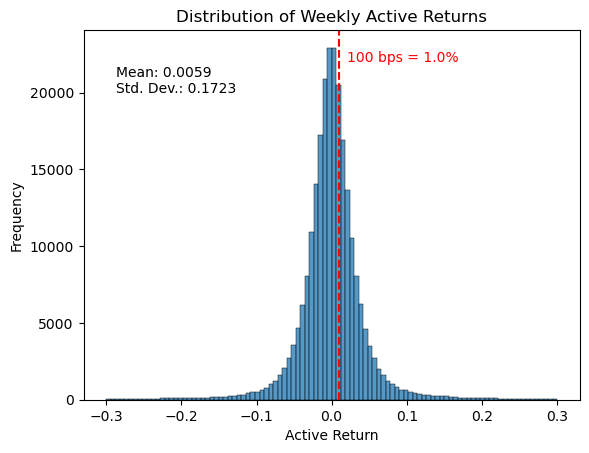

In [63]:
#is the data for ar_1w_t gaussian distributed?
import matplotlib.pyplot as plt
import seaborn as sns
# sns.histplot(featurized_active_returns_weekly["ar_1w_t"], kde=True)
# plt.show()
#reduce xlim to mean +/- 3*std
data_mean = featurized_active_returns_weekly["ar_1w_t"].mean()
data_std = featurized_active_returns_weekly["ar_1w_t"].std()
#make histplot within the range of mean +/- 3*std
sns.histplot(featurized_active_returns_weekly["ar_1w_t"],binrange=(-.3,.3),bins=100)
# plt.xlim(data_mean - 3*data_std, data_mean + 3*data_std)
plt.title("Distribution of Weekly Active Returns")
plt.xlabel("Active Return")
plt.ylabel("Frequency")
#print mean and std in top left corner
plt.text(data_mean - 1.7*data_std, 20000, f"Mean: {data_mean:.4f}\nStd. Dev.: {data_std:.4f}")
#plot line at active return = N_THRESHOLD_BPS / 10000
plt.axvline(x=N_THRESHOLD_BPS / 10000, linestyle="--",color="red")
#label this line
plt.text(N_THRESHOLD_BPS / 10000 + 0.01, 22000, f"{N_THRESHOLD_BPS} bps = {N_THRESHOLD_BPS/100}%",color="red")
plt.show()